This notebook tests all important features of the QNADE system:

*   Optimization/Training Loop
*   Gradient validation and accumulation 
*   Sample distribution generation 

```autograd_hacks.py``` 
must be uploaded to the Colab session for code to run. 


In [6]:
import math
import time
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from qnade.network import QNADE
from qnade.utils import calculate_epsilons, calculate_tfim_exact, generate_possible_states

iter: 0
iter: 10
iter: 20
iter: 30
iter: 40
iter: 50
iter: 60
iter: 70
iter: 80
iter: 90
EXPECTED ENERGY: -6.472135954999576


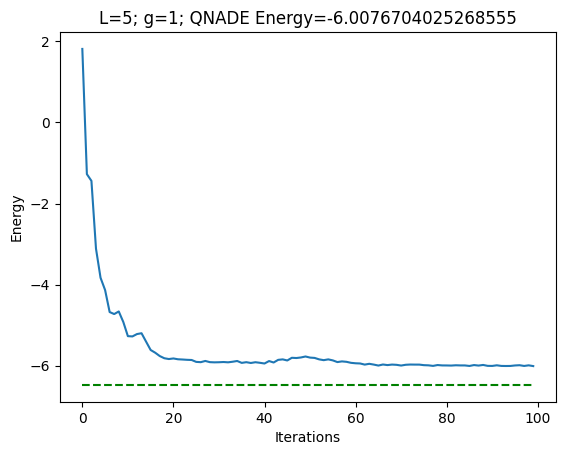

In [4]:
"""OPTIMIZATION"""

# define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# number of qubits
L = 5
H = 2 * L

J = 1  # sigma_z activation
B = 1  # sigma_x activation

# initialize network and model, put network on device
network = nn.Sequential(nn.Linear(L, H), nn.Tanh(), nn.Linear(H, 2), nn.Tanh())
network.to(device)
model = QNADE(network)
params = list(model.parameters())

# Training hyperparameters
iters = 100
batch_size = 10000
lr = 0.01

# initialize optimizer
optimizer = torch.optim.Adam(params=network.parameters(), lr=lr)
optimizer.zero_grad()

# training loop
start = time.time()
energies = []
for iter in range(iters):

    if iter % 10 == 0:
        print("iter: {}".format(iter))

    # generate data
    psi_omega, samples, grads_per_param = model(N_samples=batch_size)

    # calculate local energies
    epsilons = calculate_epsilons(model, samples, psi_omega, B, J).to(device)

    # E is an average of local energies
    E = epsilons.mean()
    energies.append(E)
    epsilons -= E

    # calculate O_k for a given parameter and number of samples
    for param in range(len(params)):

        # define O_k for a set of parameters
        O_k = grads_per_param[param].detach()

        # weight O_k according to epsilons
        O_k *= epsilons.reshape(epsilons.shape + (1,) * (O_k.ndim - 1))

        # e_grad is an average of all O_k_s
        e_grad = torch.mean(O_k, 0, keepdim=True).squeeze()

        # update network parameter matrix with energy gradient
        with torch.no_grad():
            params[param].grad.copy_(e_grad)

    # optimize network based on e_grad
    optimizer.step()

final_energy = energies[len(energies) - 1]

# plot training data
plt.figure()

if L < 12:
    expected_e = calculate_tfim_exact(L, B)
    print("EXPECTED ENERGY: {}".format(expected_e))
    expected_e_plot = [expected_e for i in range(iters)]
    plt.plot(expected_e_plot, "g--")

plt.title("L={}; g={}; QNADE Energy={}".format(L, B, final_energy))
plt.plot(energies)
plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.show()

In [5]:
"""GRADIENT VALIDATION"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# input layer size
L_in = 2

# hidden layer size
H = 2 * L_in

# number of samples
batch_size = 2

# Initialize network and model
FFNN = nn.Sequential(nn.Linear(L_in, H), nn.Tanh(), nn.Linear(H, 2), nn.Tanh()).to(
    device
)
model = QNADE(FFNN)

# generate samples, psis, and grads
WAVS, samples, grads_per_param = model(N_samples=batch_size)

# select a specific psi/grad to look at
returned_grad = grads_per_param[0][0][0][0]
psi_sampled = WAVS[0]
state = samples[0]
delta = 0.001  # amount by which to adjust a certain parameter

print("\nReturned Gradient Element: {}".format(returned_grad))

# adjust network parameter slightly
params = list(FFNN.parameters())
with torch.no_grad():
    params[0][0][0].copy_(params[0][0][0] + delta)

# generate new wavefunction coeff for a specified state based on adjusted param
psi_adj_list, samples_adj, param_grads_adj = model(N_samples=None, x=samples)
psi_adj = psi_adj_list[0]

# calculate gradient based on definition
manual_grad = (math.log(psi_adj) - math.log(psi_sampled)) / delta

print("Manually Computed Gradient Element: {}\n".format(manual_grad))


Returned Gradient Element: -0.08848535269498825
Manually Computed Gradient Element: -0.08860465848614663



/Users/calebsanders/Library/Caches/pypoetry/virtualenvs/qnade-NWh0nACy-py3.12/lib/python3.12/site-packages/torch/nn/modules/module.py:1640: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


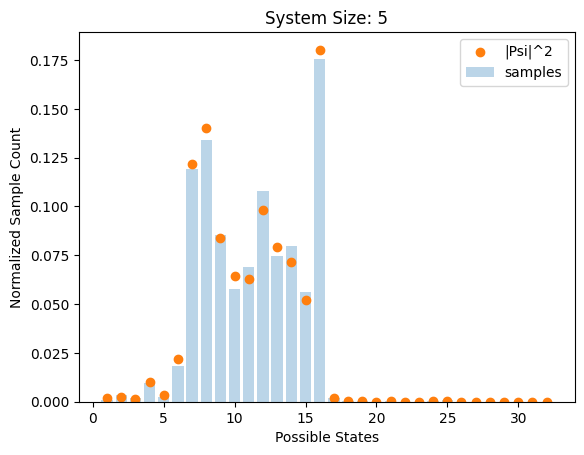

In [7]:
"""SAMPLE VALIDATION"""

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

L_in = 5
H = 2 * L_in
batch_size = 5000

# Initialize network and model
FFNN = nn.Sequential(nn.Linear(L_in, H), nn.Tanh(), nn.Linear(H, 2), nn.Tanh()).to(
    device
)
model = QNADE(FFNN)

# generate samples, psis, grads, and probabilities
WAVS, samples, _ = model(N_samples=batch_size)
WAVS = WAVS.cpu()
samples = samples.cpu()
probs = WAVS**2

# generate all theoretical possible states
possible_states = generate_possible_states(L_in)
bins = np.arange(start=1, stop=(2**L_in) + 1, step=1)

sampled_hist_data = []  # sampled state counts for each possible states
sample_prob_indices = [0] * len(possible_states)

# re-bin and organize the sampled data for plotting
for pos_state in range(len(possible_states)):
    count = 0
    for state in range(len(samples)):
        if torch.equal(samples[state], possible_states[pos_state]):
            count += 1
            sample_prob_indices[pos_state] = probs[state]

    sampled_hist_data.append(float(count))

sampled_hist_data = np.asanyarray(sampled_hist_data)
sampled_hist_data /= sum(sampled_hist_data)

plt.bar(bins, sampled_hist_data, alpha=0.3, label="samples")
plt.scatter(bins, sample_prob_indices, label="|Psi|^2")
plt.title("System Size: {}".format(L_in))
plt.xlabel("Possible States")
plt.ylabel("Normalized Sample Count")
plt.legend()
plt.show()